## Import Libraries

We import the necessary libraries for data manipulation, visualization, and modeling.


In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os, time
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-whitegrid')
%matplotlib inline

## Load Data

We load the training and test datasets. In this example, we assume that `train.csv` and `test.csv` are available in the working directory. We also impute any missing values in the test set (for `winddirection`) using the median.


In [2]:
# Load datasets and handle missing values
train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Impute missing values in test (if any) for winddirection using the median
if test['winddirection'].isnull().sum() > 0:
    test['winddirection'].fillna(test['winddirection'].median(), inplace=True)

# Define feature set and target
X = train.drop(columns=['id', 'rainfall'])
y = train['rainfall']
X_test = test.drop(columns=['id'])
test_ids = test['id']

Train shape: (2190, 13)
Test shape: (730, 12)


## Identify Outlier-Prone Columns Based on Boxplots

From the EDA performed (boxplots & distributions), we see that certain columns have distinct outliers. 
- `pressure`
- `dewpoint`
- `humidity`
- `cloud`
- `windspeed`

In [3]:
# List of columns that showed notable outliers in the images
outlier_cols = ['pressure', 'dewpoint', 'humidity', 'cloud', 'windspeed']

# If you want to treat all numeric columns, you can do:
# outlier_cols = X.columns.tolist()

## Handle Outliers Using the IQR Method

We use the Interquartile Range (IQR) method to cap (winsorize) the outliers in each numeric feature. Outliers beyond Q1 - 1.5*IQR or Q3 + 1.5*IQR are replaced by the corresponding boundary values.

In [4]:
def cap_outliers_iqr(df, columns, multiplier=1.5):
    df_capped = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        df_capped[col] = df[col].clip(lower_bound, upper_bound)
    return df_capped

# Apply outlier capping to training data
X_capped = cap_outliers_iqr(X, outlier_cols)

# Apply the same capping approach to test data
# (Note: we compute IQR boundaries from train for a strictly correct approach)
# However, you can also compute each set's boundaries if you prefer.
X_test_capped = cap_outliers_iqr(X_test, outlier_cols)

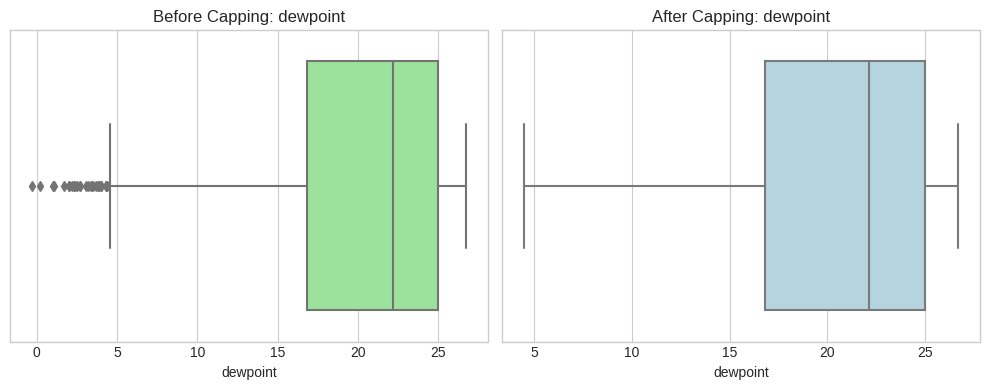

In [5]:
feature = 'dewpoint'
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.boxplot(x=X[feature], color='lightgreen')
plt.title(f"Before Capping: {feature}")

plt.subplot(1,2,2)
sns.boxplot(x=X_capped[feature], color='lightblue')
plt.title(f"After Capping: {feature}")

plt.tight_layout()
plt.show()

## Preprocessing with MinMax Scaling

We scale the features using MinMaxScaler, which scales each feature to the range [0, 1]. The scaling is applied to both the training and test data.

In [6]:
# Apply MinMax scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_capped)
X_test_scaled = scaler.transform(X_test_capped)

## Train Logistic Regression Model

We fit a logistic regression model using the preprocessed (outlier-handled and scaled) data. We also perform cross-validation (using 5-fold stratified CV) to evaluate the model’s ROC AUC score. Finally, we make predictions on the test set.

In [7]:
# Train logistic regression and evaluate using cross-validation
log_reg = LogisticRegression(solver='liblinear', max_iter=1000, penalty='l2')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate model using ROC AUC score
cv_scores = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='roc_auc')
print("Cross-validated ROC AUC scores:", cv_scores)
print("Mean ROC AUC score:", cv_scores.mean())

# Fit the model on the full training set
log_reg.fit(X_scaled, y)

# Generate predictions for the test set (probability for class 1)
test_preds = log_reg.predict_proba(X_test_scaled)[:, 1]

# Create submission DataFrame
submission_df = pd.DataFrame({'id': test_ids, 'rainfall': test_preds})
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Cross-validated ROC AUC scores: [0.92025814 0.86141975 0.87819865 0.9099046  0.89873737]
Mean ROC AUC score: 0.8937037037037039
Submission file saved as 'submission.csv'
